<font size="8">Trace Analysis Examples</font>
<br>
<font size="5">Tasks Latencies</font>
<br>
<hr>

# Import Required Modules

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

# Target Configuration

In [4]:
# Setup target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../android-sdk")
my_conf = {

    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
#             'ip_address'     : '10.65.34.1',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Folder where all the results will be collected
    "results_dir" : "Task_Latencies",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],

}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf)
target = te.target

04:10:02  INFO    : Using base path: /home/steven/lisa/lisa-github
04:10:02  INFO    : Loading custom (inline) target configuration
04:10:02  WARNING : Wipe previous contents of the results folder:
04:10:02  WARNING :    /home/steven/lisa/lisa-github/results/Task_Latencies
04:10:02  INFO    : External tools using:
04:10:02  INFO    :    ANDROID_HOME: /home/steven/lisa/lisa-github/ipynb/workshop/../../../android-sdk
04:10:02  INFO    :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
04:10:03  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
04:10:03  INFO    : Connecting Android target [0123456789ABCDEF]
04:10:03  INFO    : Connection settings:
04:10:03  INFO    :    {'device': '0123456789ABCDEF'}
04:10:07  INFO    : Initializing target workdir:
04:10:07  INFO    :    /data/local/tmp/devlib-target
04:10:13  INFO    : Attempting to read energy model from target
04:10:16  INFO    : Topology:
04:10:16  INFO    :    [[0, 1, 2, 3], [4, 5, 6, 7]]
04:10:16  INFO   

# Workload Execution

In [6]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [7]:
experiment(te)

04:10:17  INFO    : Setup new workload ramp
04:10:18  INFO    : Workload duration defined by longest task
04:10:18  INFO    : Default policy: SCHED_OTHER
04:10:18  INFO    : ------------------------
04:10:18  INFO    : task [ramp], sched: using default policy
04:10:18  INFO    :  | loops count: 1
04:10:18  INFO    : + phase_000001: duration 0.500000 [s] (5 loops)
04:10:18  INFO    : |  period   100000 [us], duty_cycle  60 %
04:10:18  INFO    : |  run_time  60000 [us], sleep_time  40000 [us]
04:10:18  INFO    : + phase_000002: duration 0.500000 [s] (5 loops)
04:10:18  INFO    : |  period   100000 [us], duty_cycle  55 %
04:10:18  INFO    : |  run_time  55000 [us], sleep_time  45000 [us]
04:10:18  INFO    : + phase_000003: duration 0.500000 [s] (5 loops)
04:10:18  INFO    : |  period   100000 [us], duty_cycle  50 %
04:10:18  INFO    : |  run_time  50000 [us], sleep_time  50000 [us]
04:10:18  INFO    : + phase_000004: duration 0.500000 [s] (5 loops)
04:10:18  INFO    : |  period   100000 [

# Parse Trace and Profiling Data

In [8]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

04:10:33  INFO    : Content of the output folder /home/steven/lisa/lisa-github/results/Task_Latencies


/home/steven/lisa/lisa-github/results/Task_Latencies
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── rt-app-ramp_1-2.log
├── rt-app-ramp_1-4.log
├── rt-app-ramp_2-3.log
├── rt-app-ramp_2-5.log
└── trace.dat

0 directories, 9 files


In [9]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

04:10:33  INFO    : LITTLE cluster max capacity: 462


In [10]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

# Trace visualization

In [11]:
trappy.plotter.plot_trace(trace.ftrace)

# Latency DataFrames

In [12]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

04:10:36  INFO    : Parsing sched_switch states assuming kernel v4.9
04:10:36  INFO    : Parsing sched_switch states assuming kernel v4.9
04:10:36  INFO    : Parsing sched_switch states assuming kernel v4.9
04:10:36  INFO    : Parsing sched_switch states assuming kernel v4.9


,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.914003,NaN,2.0,A,R,0.914003,0.004722
0.918725,NaN,2.0,R,A,0.918725,0.001978
0.920703,NaN,2.0,A,R,0.920703,0.042076
0.962779,NaN,2.0,R,A,0.962779,0.000350
0.963129,NaN,4.0,A,R,0.963129,0.011501


In [13]:
trace.data_frame.latency_df('ramp')

,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.914003,NaN,2.0,A,R,0.914003,0.004722
0.918725,NaN,2.0,R,A,0.918725,0.001978
0.920703,NaN,2.0,A,R,0.920703,0.042076
0.962779,NaN,2.0,R,A,0.962779,0.000350
0.963129,NaN,4.0,A,R,0.963129,0.011501
0.974630,NaN,4.0,R,A,0.974630,0.000174
0.974804,NaN,4.0,A,R,0.974804,0.019806
0.994610,NaN,4.0,R,A,0.994610,0.000133
0.994743,NaN,4.0,A,R,0.994743,0.063833


In [14]:
df = trace.data_frame.trace_event('sched_switch')
df.head()

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
0.000107,trace-cmd,0,7,7493,shell srvc 7489,7490,120,trace-cmd,7493,120,4096
0.000469,<idle>,2,13,0,adbd,3128,120,swapper/2,0,120,4096
0.000595,shell,0,18,7490,trace-cmd,7493,120,shell srvc 7489,7490,120,1
0.001418,<idle>,3,24,0,->transport,3136,120,swapper/3,0,120,4096
0.001845,<idle>,1,37,0,irq/337-dwc3,3130,49,swapper/1,0,120,4096


In [15]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

,wakeup_latency
Time,
1.119596,0.000119
1.319853,0.000021
1.419566,0.000008
1.519815,0.000122
1.619820,0.000012


In [16]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

,preempt_latency
Time,
0.918725,0.001978
0.962779,0.000350
0.974630,0.000174
0.994610,0.000133
1.058576,0.000241


## Latency Plots

04:11:45  INFO    : Parsing sched_switch states assuming kernel v4.9
04:11:45  INFO    : Parsing sched_switch states assuming kernel v4.9
04:11:45  INFO    : Parsing sched_switch states assuming kernel v4.9
04:11:45  INFO    : Parsing sched_switch states assuming kernel v4.9
04:11:45  INFO    : Found:    41 WAKEUP latencies
04:11:45  INFO    : Found:   116 PREEMPT latencies
04:11:45  INFO    : Total:   157 latency events
04:11:45  INFO    : 96.8 % samples below 1 [ms] threshold
04:11:45  WARNING : Event [sched_overutilized] not found, plot DISABLED!


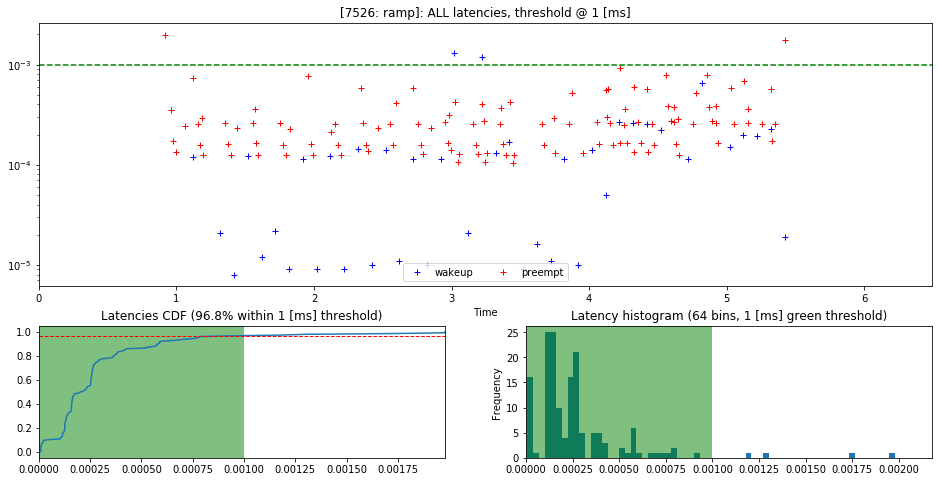

In [17]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

In [18]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max,96.8%
latency,157.0,0.000272,0.000277,0.000008,0.000198,0.000741,0.001495,0.001978,0.001


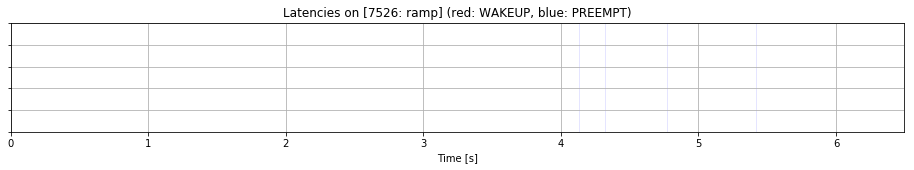

In [19]:
# Plot latency events for a specified task
trace.analysis.latency.plotLatencyBands('ramp')

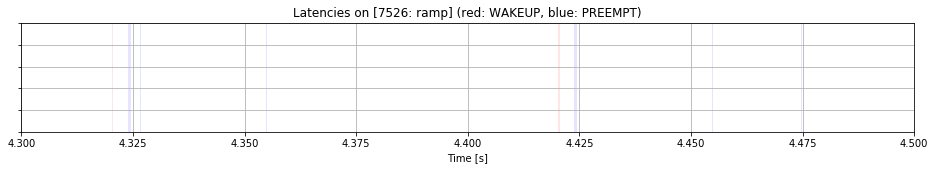

In [20]:
# Zoom into a spefific time frame
#trace.setXTimeRange(3.445, 3.45)
trace.setXTimeRange(4.3, 4.5)
trace.analysis.latency.plotLatencyBands('ramp')